# **Sentiment Analysis of Twitter Text Data in Python**

### This is the Python notebook for sentiment analysis in Python. The following techniques will be utilized:

1. **VADER (Valence Aware Dictionary and Sentiment Reasoner) Model** : Bag of Words Approach 
2. **RoBERTa (Robustly Optimized Bidirectional Encoder Representations from Transformers) Model** : Contextualized Embeddings Approach

# **Step 1: Read Data and Data Preprocessing**

Import libraries for the following: 
- Data Manipulation 
- Data Visualization 
- Natural Language Processing (NLP) 
- Exploratory Data Analysis (EDA)

In [1]:
# Data manipulation and analysis
import pandas as pd    # For handling data in DataFrames, for data manipulation, cleaning, and analysis.
import numpy as np     # For numerical operation, arrays, and advanced math functions.

# Visualization libraries
import matplotlib.pyplot as plt    # For creating static, animated, and interactive visualizations.
import seaborn as sns              # High-level interface for creating attractive and informative statistical graphs.

# EDA (Exploratory Data Analysis) modules
import nltk                             # Natural Language Toolkit, for working with human language data (text).
from nltk.corpus import stopwords       # For importing stopwords ('the', 'is') to exclude in text analysis.
from collections import Counter         # For counting frequency of elements in list.
from nltk.tokenize import word_tokenize # For splitting text into individual words (tokens). 
from nltk import pos_tag                # For parts of speech (POS) tagging in tokenized text, For linguistic analysis.
import re                               # Regular expressions for pattern matching, useful for cleaning or extracting text.

# Plotting style
plt.style.use('ggplot')     # Sets particular plotting style, for polished plots.

Load the dataset from a CSV file into a DataFrame

In [2]:
df = pd.read_csv('text_modified.csv') 
print(df.shape)

(416809, 3)


Limit dataset to first 1000 rows for analysis

In [3]:
df = df.head(1000) 
print(df.shape)

(1000, 3)


Display first 5 rows of the dataset

In [4]:
df.head()

,Index,text,label
0,0,i just feel really helpless and heavy hearted,Fear
1,1,ive enjoyed being able to slouch about relax a...,Sadness
2,2,i gave up my internship with the dmrg and am f...,Fear
3,3,i dont know i feel so lost,Sadness
4,4,i am a kindergarten teacher and i am thoroughl...,Fear


## Data Cleaning

- This step is vital because it ensures that the dataset is free from noise, inconsistencies, and irrelevant information, making the data more accurate and reliable for analysis. For the code below, the preprocessing step helps remove unnecessary elements like stopwords, special characters, and numbers, allowing for more meaningful insights from the text data.

In [5]:
stop_words = set(stopwords.words('english')) 

# Extend stopwords 
custom_stop_words = {
    "i", 
    "im", 
    "ive", 
    "dont", 
    "and", 
    "you", 
    "he", 
    "she", 
    "we", 
    "they", 
    "it", 
    "is", 
    "are", 
    "was", 
    "were", 
    "their", 
    "there"
}
stop_words.update(custom_stop_words) 

# Preprocess text (lowercase, remove stopwords, tokenize) 
def preprocess_text(text): 
    # Convert lowercase 
    text = text.lower()
    # Remove special characters and numbers 
    text = re.sub(r'\W+', ' ', text) 
    # Tokenize 
    words = text.split() 
    # Remove stopwords 
    words = [word for word in words if word not in stop_words] 
    return words 

# Apply preprocessing to dataset 
df['processed_text'] = df['text'].apply(preprocess_text)
df.head()

,Index,text,label,processed_text
0,0,i just feel really helpless and heavy hearted,Fear,"[feel, really, helpless, heavy, hearted]"
1,1,ive enjoyed being able to slouch about relax a...,Sadness,"[enjoyed, able, slouch, relax, unwind, frankly..."
2,2,i gave up my internship with the dmrg and am f...,Fear,"[gave, internship, dmrg, feeling, distraught]"
3,3,i dont know i feel so lost,Sadness,"[know, feel, lost]"
4,4,i am a kindergarten teacher and i am thoroughl...,Fear,"[kindergarten, teacher, thoroughly, weary, job..."


# Exploratory Data Analysis

- This step is vital for text sentiment analysis because it helps to understand the underlying structure, patterns, and key features of the data. By performing EDA, we can identify trends, clean the data, and better prepare it for building accurate sentiment models, ensuring insights are derived from meaningful and relevant information.

Visualizing the distribution of each sentiment label in the sample data.

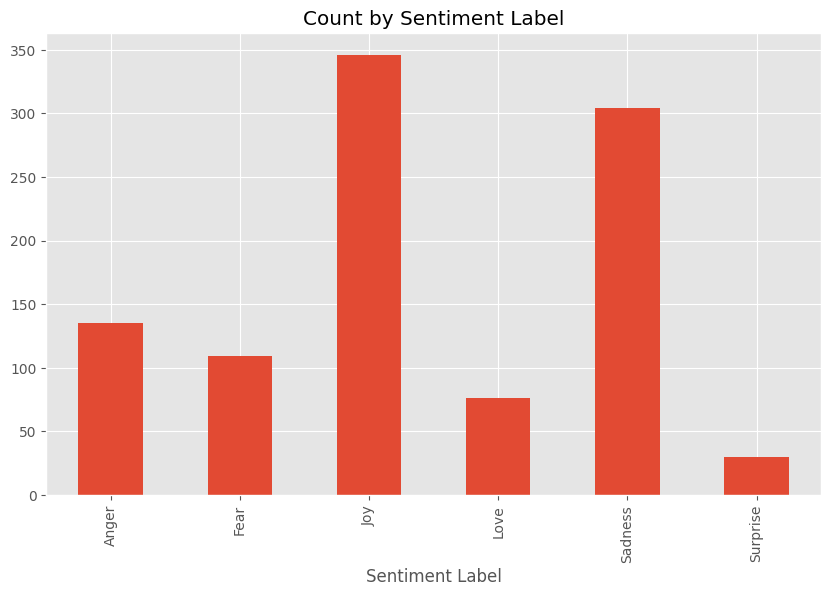

In [6]:
ax = df['label'].value_counts().sort_index().plot(
    kind = 'bar', 
    title = 'Count by Sentiment Label', 
    figsize = (10, 6)
) 
ax.set_xlabel('Sentiment Label') 
plt.show()

Display the specific counts of each sentiment label.

In [7]:
count = df['label'].value_counts()
count

label
Joy         346
Sadness     304
Anger       135
Fear        109
Love         76
Surprise     30
Name: count, dtype: int64

## Distribution of Emotions

### 1) Are certain emotions more prevalent than others in the dataset?

The emotions of Joy and Sadness are more prevalent with 346 and 304 instances respectively. These emotions are more dominant in contrast to Love with 76 instances, Anger with 135 instances, Fear with 109 instances, and Surprise with only 30 instances.
<br><br>

### 2) What is the frequency distribution of each emotion in the dataset?

The following are the number of tweets per emotions:
- **Sadness**: 304
- **Joy**: 346
- **Love**: 76
- **Anger**: 135
- **Fear**: 109
- **Surprise**: 30

### Data Normalization

- Data normalization is important because it helps balance the uneven distribution of senitment labels in the dataset. By ensuring that each emotion label is represented more equally, normalization prevents models from becoming biased towards the more frequent emotions. This results to more accurate and efficient analysis, as the model will better understand and predict all emotions rather than focusing on the majority class.

In [8]:
# Import resample method to tackle imbalance in dataset.
from sklearn.utils import resample 

# Check current distribution of sentiment labels in the dataset.
label_counts = df['label'].value_counts() 
print(label_counts)

label
Joy         346
Sadness     304
Anger       135
Fear        109
Love         76
Surprise     30
Name: count, dtype: int64


Find the maximum count of all the labels to use as the reference for upsampling.

In [9]:
max_count = df['label'].value_counts().max() 
print('Max: ', max_count)

Max:  346


Upsample all sentiment labels to match the maximum value

In [10]:
# Prepare empty list to hold upsampled DataFrames.
upsampled_dfs = [] 

# Iterate over each unique sentiment label in the dataset.
for label in df['label'].unique(): 
    # Filter DataFrame to get all rows corresponding to the current label.
    label_df = df[ df['label'] == label ] 

    # Perform upsampling to match number of samples for certain label to the max_count.
    upsampled_df = resample(
        label_df, 
        replace = True,         # Allow replacement to perform upsampling.
        n_samples = max_count,  # Set the number of samples to the maximum count.
        random_state = 42       # Random state for reproducibility.
    )
    
    # Append upsampled DataFrame to the list.
    upsampled_dfs.append(upsampled_df)

# Concatenate all upsampled DataFrames to form final upsampled dataset.
upsampled_df = pd.concat(upsampled_dfs)

Print new label distribution after upsampling.

In [11]:
print(upsampled_df['label'].value_counts())

label
Fear        346
Sadness     346
Love        346
Joy         346
Surprise    346
Anger       346
Name: count, dtype: int64


Sample 1000 random rows from the upsampled DataFrame.

In [12]:
df = upsampled_df.sample(n = 1000, random_state = 42) 
print(df['label'].value_counts())

label
Sadness     177
Surprise    169
Fear        166
Love        164
Anger       164
Joy         160
Name: count, dtype: int64


Plot normalized count of each sentiment label after upsampling

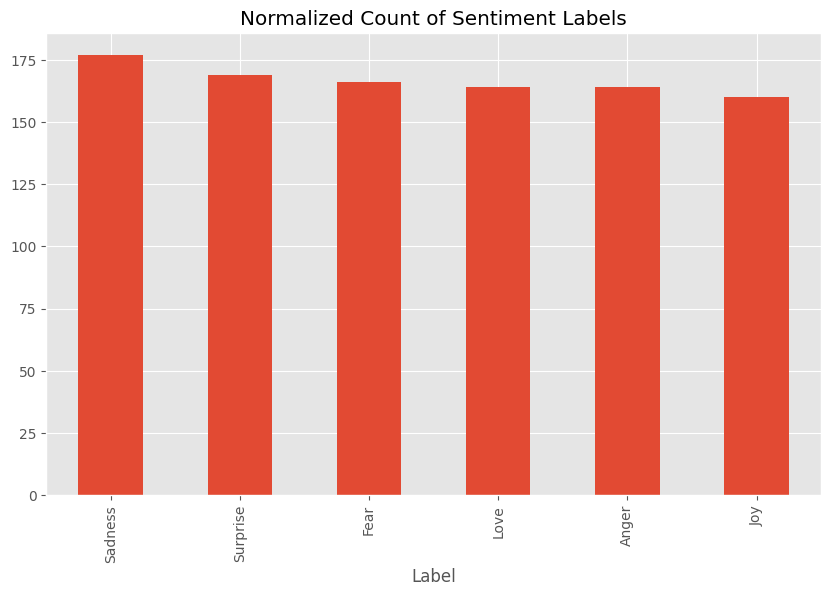

In [13]:
new_label_counts = df['label'].value_counts() 

ax = new_label_counts.plot(
    kind = 'bar', 
    title = 'Normalized Count of Sentiment Labels', 
    figsize = (10, 6)
) 

ax.set_xlabel('Label') 
plt.show()

Calculate and add two new columns: character count and word count.

In [14]:
# Add column 'char_count' that calculates total number of characters in each tweet.
df['char_count'] = df['processed_text'].apply(lambda x: sum(len(word) for word in x))

# Add column 'word_count' that calculates total number of word in each tweet.
df['word_count'] = df['processed_text'].apply(len)

# Display first few rows with processed text, character count, and word count columns.
df[['processed_text', 'char_count', 'word_count']].head()

,processed_text,char_count,word_count
90,"[want, sit, inside, alone, want, nothing, also...",55,10
161,"[feel, generous, follow, mostly, endure, like,...",78,13
568,"[hopeful, normalcy, around, corner, grateful, ...",74,12
880,"[feeling, uncertain, putting, blog, right, doe...",57,10
408,"[feeling, blessed, thanksgiving, break, opport...",62,8


Calculates average word count for each emotion label in the dataset.

In [15]:
# Group DataFrame by 'label' and calculate mean word count for each label.
avg_word_count_by_emotion = df.groupby('label')['word_count'].mean()
avg_word_count_by_emotion

label
Anger       9.615854
Fear        9.259036
Joy         8.306250
Love        9.664634
Sadness     9.129944
Surprise    9.443787
Name: word_count, dtype: float64

## Emotion by Word Count

### 3) What are the average word counts of the tweets of the different emotions?

The following are the average word counts of tweets per emotions:
- **Sadness**: 9.129944
- **Joy**: 8.306250
- **Love**: 9.664634
- **Anger**: 9.615854
- **Fear**: 9.259036
- **Surprise**: 9.443787


Categorize tweets into 'Short' or 'Long' based on the word count, and plots the distribution of emotions for each length.

In [16]:
# Add column 'message_length' that classifies each tweet as 'Short' or 'Long' based on whether word count is 10 or less.
df['message_length'] = df['word_count'].apply(lambda x: 'Short' if x <= 10 else 'Long') 

# Calculate distribution of emotions across tweet length categories (Short vs Long). 
# Group by message length and label, then calculate size of each group. 
# Unstack to create DataFrame with 'label' as columns.
length_emotion_distribution = df.groupby(['message_length', 'label']).size().unstack(fill_value = 0)

# Add 'Total' row and column to DataFrame to show total counts.
length_emotion_distribution.loc['Total'] = length_emotion_distribution.sum() 
length_emotion_distribution['Total'] = length_emotion_distribution.sum(axis = 1) 

# Display emotion distribution by tweet length.
length_emotion_distribution 

label,Anger,Fear,Joy,Love,Sadness,Surprise,Total
message_length,,,,,,,
Long,58,62,42,65,63,44,334
Short,106,104,118,99,114,125,666
Total,164,166,160,164,177,169,1000


Plot distribution of emotions across tweet length categories.

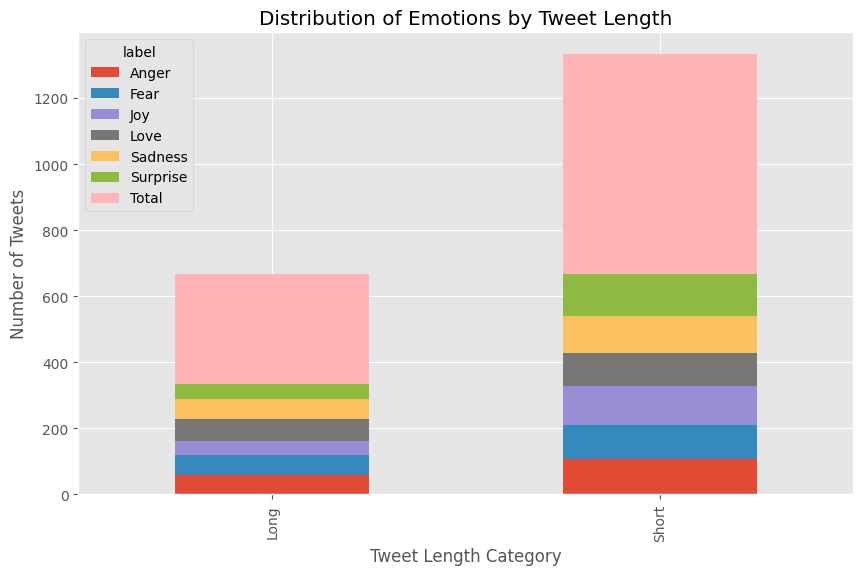

In [17]:
length_emotion_distribution.drop('Total').plot(
    kind = 'bar', 
    stacked = True, 
    figsize = (10, 6)
)
plt.title('Distribution of Emotions by Tweet Length')
plt.xlabel('Tweet Length Category')
plt.ylabel('Number of Tweets')
plt.show()

## Word Frequency

### 4) Are shorter or longer messages more likely to express certain emotions?

The table below shows the counts of emotions expressed in short and long messages:

| Length Category | Sadness | Joy   | Love | Anger | Fear | Surprise | **Total** |
|-----------------|---------|-------|------|-------|------|----------|-----------|
| **Long**        | 58    | 62  | 42 | 65  | 63 | 44      | **334** |
| **Short**       | 106    | 104 | 118 | 99  | 114 | 125     | **666** |
| **Total**       | **164** | **166** | **160** | **164** | **177** | **169** | **1000** |

Count common words for each emotion

In [18]:
common_words = {}
for label in df['label'].unique():
    # Get all processed words for the emotion
    words = df[df['label'] == label]['processed_text'].sum()  # Flatten the list of lists
    common_words[label] = Counter(words).most_common(10)  # Get the 10 most common words

# Display the most common words for each emotion
for emotion, words in common_words.items():
    print(f"Most common words for '{emotion}':")
    print(words)
    print()

Most common words for 'Fear':
[('feel', 102), ('feeling', 66), ('like', 29), ('still', 17), ('time', 15), ('want', 14), ('starting', 13), ('every', 13), ('know', 12), ('scared', 12)]

Most common words for 'Joy':
[('feel', 120), ('feeling', 45), ('like', 17), ('blog', 11), ('time', 11), ('love', 10), ('though', 10), ('really', 10), ('perfect', 9), ('terrific', 8)]

Most common words for 'Love':
[('feel', 104), ('feeling', 61), ('like', 42), ('would', 25), ('really', 24), ('lovely', 18), ('still', 18), ('nostalgic', 13), ('getting', 12), ('get', 12)]

Most common words for 'Surprise':
[('feel', 132), ('feeling', 49), ('like', 34), ('know', 31), ('strange', 31), ('weird', 31), ('also', 30), ('amazed', 22), ('could', 20), ('think', 20)]

Most common words for 'Anger':
[('feel', 115), ('feeling', 54), ('like', 31), ('know', 15), ('getting', 15), ('think', 14), ('cranky', 14), ('bit', 13), ('really', 12), ('people', 12)]

Most common words for 'Sadness':
[('feel', 121), ('feeling', 55), ('l

### 5) What are the most common words used in tweets for each emotion?

The following are the most common words used in Twitter messages for each emotion:

- **Fear:**
  - "feel" (3646), "feeling" (2090), and "like" (750)
  
- **Sadness:**
  - "feel" (10249), "feeling" (4906), and "like" (2654)
  
- **Love:**
  - "feel" (2903), "love" (272), and "like" (923)
  
- **Joy:**
  - "feel" (12422), "feeling" (4854), and "like" (3070)
  
- **Surprise:**
  - "feel" (1204), "feeling" (669), and "like" (296)
  
- **Anger:**
  - "feel" (4470), "feeling" (2271), and "like" (1228)

Words such as "feel", "feeling", and "like" are prominent across all emotions.

Graph distribution of text character counts.

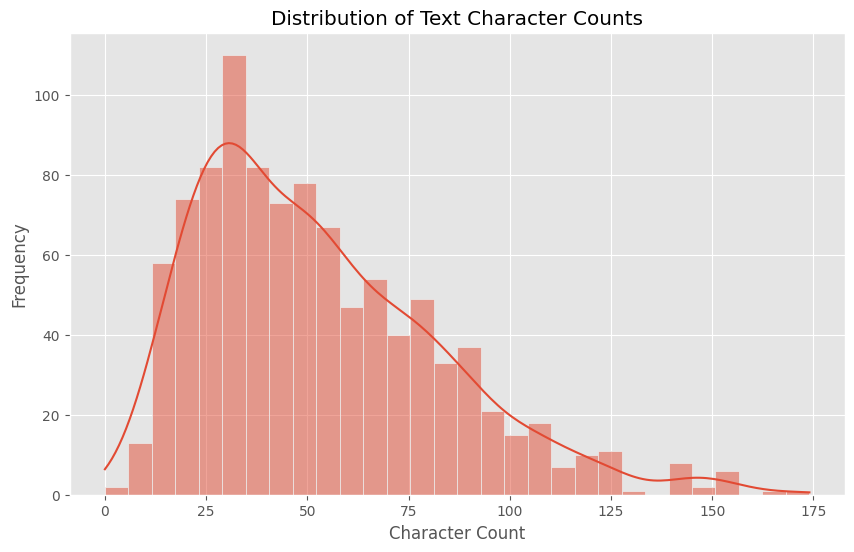

In [19]:
plt.figure(figsize = (10, 6)) 
sns.histplot( df['char_count'], bins = 30, kde = True ) 
plt.title('Distribution of Text Character Counts') 
plt.xlabel('Character Count') 
plt.ylabel('Frequency') 
plt.show()

- The graph represents the distribution of character counts in the text data. X-axis shows the number of characters per text, while the y-axis shows the frequency or number of texts that have a paticular character count. 

- The red line represents the Kernel Density Estimation (KDE), which shows the estimated probability density of the character count distribution. From the graph, most of the texts in the dataset have around 25 to 50 characters, with a peak of around 35 characters. As the character count increseases beyond 50, the frequency of texts with higher character counts gradually decreases.

Graph distribution of text word counts.

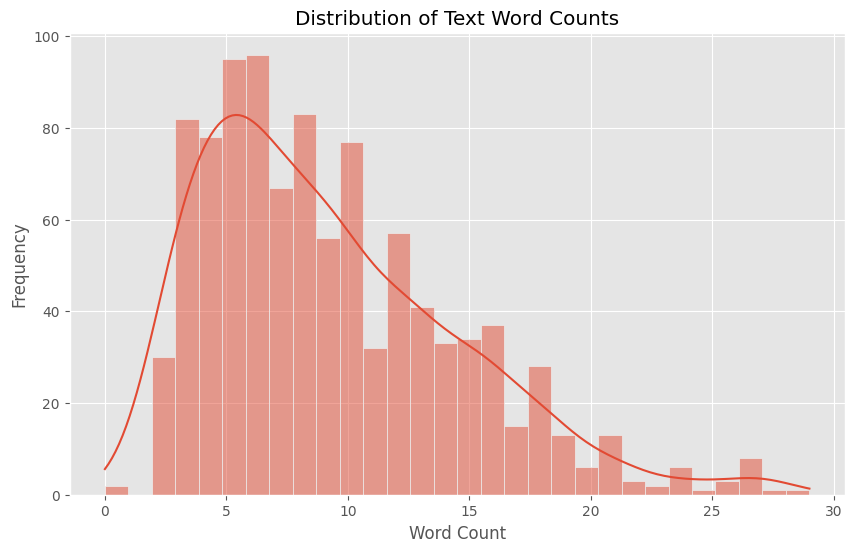

In [20]:
plt.figure(figsize = (10, 6)) 
sns.histplot( df['word_count'], bins = 30, kde = True ) 
plt.title('Distribution of Text Word Counts') 
plt.xlabel('Word Count') 
plt.ylabel('Frequency') 
plt.show()

- The graph represents the distribution of word counts in the text data. X-axis shows the number of words per text, while the y-axis shows the frequency or number of texts that have a paticular word count. 

- The red line represents the Kernel Density Estimation (KDE), which shows the estimated probability density of the word count distribution. From the graph, it can be observed that most text contains around 5 to 10 words, with a peak at about 6 words. As word counts increases beyond 10, the frequency of texts with higher word counts decreases steadily. This suggests that most texts in the dataset are relatively short, with very few texts containing more than 20 words.

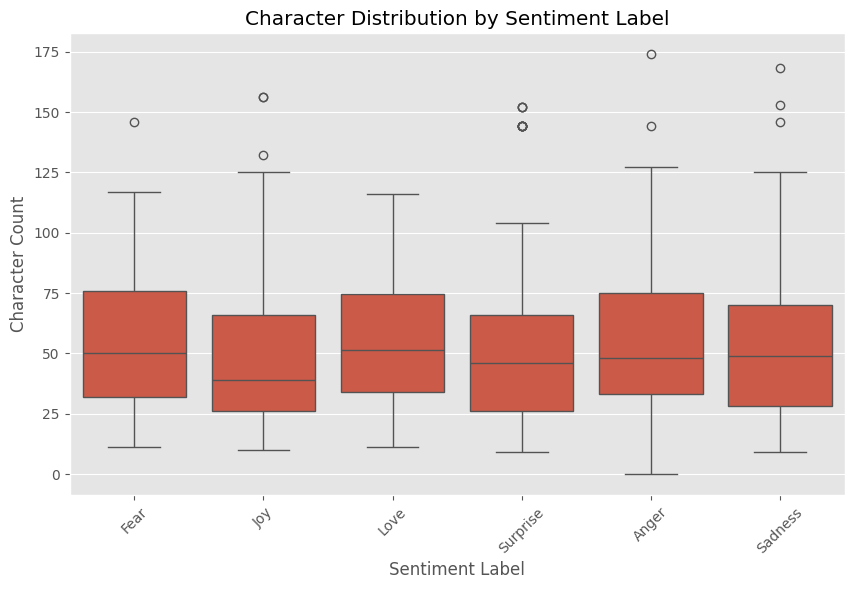

In [21]:
plt.figure(figsize = (10, 6)) 
sns.boxplot(x = 'label', y = 'char_count', data = df) 
plt.title('Character Distribution by Sentiment Label') 
plt.xlabel('Sentiment Label') 
plt.ylabel('Character Count') 
plt.xticks(rotation = 45) 
plt.show()

- The box plot visualizes the character distribution of texts across different sentiment labels: Fear, Joy, Love, Surprise, Anger, and Sadness. The y-axis represents number of characters in each text, while the x-axis shows the different sentiment labels.

- **Box and Whiskers:**
    - The box represents the interquartile range (IQR), which contains the middle 50% of the data. The bottom of the box shows the first quartile (25th percentile), the top shows the third quartile (75th percentile), and the line in the middle of the box is the median (50th percentile). 

    - The whiskers extending from the box represents the range of the data within 1.5 times the IQR from the first and third quartiles.

- **Circles (Outliers):** 
    - The circles above the whiskers represent the outliers--data points that fall outside 1.5 times the IQR. These are texts with unusually high character coutns compared to the majority of texts within the specific sentiment label. For example, Fear and Anger labels show some texts that have significantly higher character counts than others, which results in them being marked as outliers.

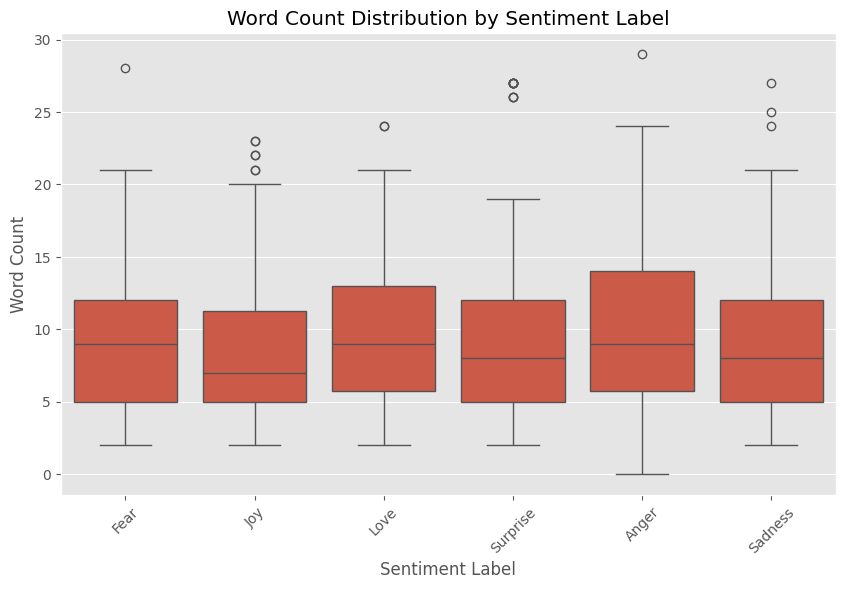

In [22]:
plt.figure(figsize = (10, 6)) 
sns.boxplot(x = 'label', y = 'word_count', data = df) 
plt.title('Word Count Distribution by Sentiment Label') 
plt.xlabel('Sentiment Label') 
plt.ylabel('Word Count') 
plt.xticks(rotation = 45) 
plt.show()

- The box plot visualizes the word count distribution of texts across different sentiment labels: Fear, Joy, Love, Surprise, Anger, and Sadness. The y-axis represents word count in each text, while the x-axis shows the different sentiment labels.

- **Box and Whiskers:**
    - The box represents the interquartile range (IQR), which contains the middle 50% of the data. The bottom of the box shows the first quartile (25th percentile), the top shows the third quartile (75th percentile), and the line in the middle of the box is the median (50th percentile). 

    - The whiskers extending from the box represents the range of the data within 1.5 times the IQR from the first and third quartiles.

- **Circles (Outliers):** 
    - The circles above the whiskers represent the outliers--data points that fall outside 1.5 times the IQR. These are texts with unusually high character coutns compared to the majority of texts within the specific sentiment label. For example, Fear and Anger labels show some texts that have significantly higher character counts than others, which results in them being marked as outliers.

# NLTK

In [23]:
example = ' '.join(df['processed_text'].iloc[5] )
print(example)

feel like hope gained wisdom still choices struggle decisions afraid make fear long term ramifications still pieces feel like know better


In [24]:
tokens = nltk.word_tokenize(example) 
tokens[:10]

['feel',
 'like',
 'hope',
 'gained',
 'wisdom',
 'still',
 'choices',
 'struggle',
 'decisions',
 'afraid']

In [25]:
tagged = nltk.pos_tag(tokens) 
tagged[:10]

[('feel', 'NN'),
 ('like', 'IN'),
 ('hope', 'NN'),
 ('gained', 'VBN'),
 ('wisdom', 'NN'),
 ('still', 'RB'),
 ('choices', 'VBZ'),
 ('struggle', 'JJ'),
 ('decisions', 'NNS'),
 ('afraid', 'VBP')]

In [26]:
entities = nltk.ne_chunk(tagged) 
entities.pprint()

(S
  feel/NN
  like/IN
  hope/NN
  gained/VBN
  wisdom/NN
  still/RB
  choices/VBZ
  struggle/JJ
  decisions/NNS
  afraid/VBP
  make/VBP
  fear/NN
  long/JJ
  term/NN
  ramifications/NNS
  still/RB
  pieces/NNS
  feel/VBP
  like/IN
  know/VBP
  better/JJR)


In [27]:
def process_tokens(tokens): 
    pos_tags = pos_tag(tokens) 
    return tokens, pos_tags

df['tokens'], df['pos_tags'] = zip( *df['processed_text'].apply(process_tokens) ) 
print(df[['tokens', 'pos_tags']].head())

                                                tokens  \
90   [want, sit, inside, alone, want, nothing, also...   
161  [feel, generous, follow, mostly, endure, like,...   
568  [hopeful, normalcy, around, corner, grateful, ...   
880  [feeling, uncertain, putting, blog, right, doe...   
408  [feeling, blessed, thanksgiving, break, opport...   

                                              pos_tags  
90   [(want, JJ), (sit, NN), (inside, IN), (alone, ...  
161  [(feel, NN), (generous, JJ), (follow, VBP), (m...  
568  [(hopeful, JJ), (normalcy, NN), (around, IN), ...  
880  [(feeling, VBG), (uncertain, JJ), (putting, VB...  
408  [(feeling, VBG), (blessed, VBN), (thanksgiving...  


# VADER Sentiment Scoring

In [28]:
from nltk.sentiment import SentimentIntensityAnalyzer 
from tqdm.notebook import tqdm 

sia = SentimentIntensityAnalyzer()

In [29]:
sia.polarity_scores('I hate my life')

{'neg': 0.649, 'neu': 0.351, 'pos': 0.0, 'compound': -0.5719}

In [30]:
sia.polarity_scores('I love you')

{'neg': 0.0, 'neu': 0.192, 'pos': 0.808, 'compound': 0.6369}

In [31]:
sia.polarity_scores(example)

{'neg': 0.156, 'neu': 0.368, 'pos': 0.476, 'compound': 0.8834}

In [32]:
res = {}

for i, row in tqdm( df.iterrows(), total = len(df) ): 
    text = row['text'] 
    id = row['Index']
    res[id] = sia.polarity_scores(text)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [33]:
vaders = pd.DataFrame(res).T
vaders = vaders.reset_index().rename(columns = {
    'index': 'id', 
    'neg': 'vader_neg', 
    'neu': 'vader_neu', 
    'pos': 'vader_pos'
})  # Renaming index to 'id'

# If 'id' corresponds to the index of df, you can merge on 'id'
vaders = vaders.merge(df, how='left', left_on='id', right_on='Index')

In [34]:
vaders

,id,vader_neg,vader_neu,vader_pos,compound,Index,text,label,processed_text,char_count,word_count,message_length,tokens,pos_tags
0,90,0.185,0.648,0.167,-0.3400,90,i don t want to sit inside and be alone i don ...,Fear,"[want, sit, inside, alone, want, nothing, also...",55,10,Short,"[want, sit, inside, alone, want, nothing, also...","[(want, JJ), (sit, NN), (inside, IN), (alone, ..."
1,90,0.185,0.648,0.167,-0.3400,90,i don t want to sit inside and be alone i don ...,Fear,"[want, sit, inside, alone, want, nothing, also...",55,10,Short,"[want, sit, inside, alone, want, nothing, also...","[(want, JJ), (sit, NN), (inside, IN), (alone, ..."
2,161,0.000,0.778,0.222,0.6757,161,i feel generous and i follow but mostly i endu...,Joy,"[feel, generous, follow, mostly, endure, like,...",78,13,Long,"[feel, generous, follow, mostly, endure, like,...","[(feel, NN), (generous, JJ), (follow, VBP), (m..."
3,161,0.000,0.778,0.222,0.6757,161,i feel generous and i follow but mostly i endu...,Joy,"[feel, generous, follow, mostly, endure, like,...",78,13,Long,"[feel, generous, follow, mostly, endure, like,...","[(feel, NN), (generous, JJ), (follow, VBP), (m..."
4,568,0.074,0.617,0.309,0.8449,568,i am hopeful that normalcy is just around the ...,Love,"[hopeful, normalcy, around, corner, grateful, ...",74,12,Long,"[hopeful, normalcy, around, corner, grateful, ...","[(hopeful, JJ), (normalcy, NN), (around, IN), ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,991,0.355,0.645,0.000,-0.5106,991,i feel dumb that this is the case,Sadness,"[feel, dumb, case]",12,3,Short,"[feel, dumb, case]","[(feel, VB), (dumb, JJ), (case, NN)]"
996,818,0.000,0.593,0.407,0.6705,818,i feel like he is going to be such a sweet heart,Love,"[feel, like, going, sweet, heart]",23,5,Short,"[feel, like, going, sweet, heart]","[(feel, NN), (like, IN), (going, VBG), (sweet,..."
997,295,0.437,0.563,0.000,-0.4767,295,i feel a bit ashamed about it,Sadness,"[feel, bit, ashamed]",14,3,Short,"[feel, bit, ashamed]","[(feel, VB), (bit, NN), (ashamed, JJ)]"
998,647,0.149,0.749,0.103,-0.4642,647,i do not want these problems although he did n...,Fear,"[want, problems, although, admitted, know, mus...",80,14,Long,"[want, problems, although, admitted, know, mus...","[(want, VB), (problems, NNS), (although, IN), ..."


## Plot VADER Results

C:\Users\arche\AppData\Local\Temp\ipykernel_5528\709517055.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation = 45, ha = "right", fontsize = 12)


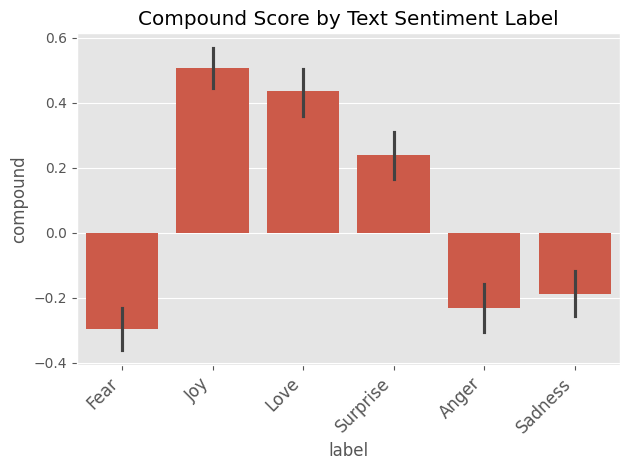

In [35]:
ax = sns.barplot(
    data = vaders, 
    x = 'label', 
    y = 'compound'
)
ax.set_title('Compound Score by Text Sentiment Label')
ax.set_xticklabels(ax.get_xticklabels(), rotation = 45, ha = "right", fontsize = 12) 
plt.tight_layout() 
plt.show()

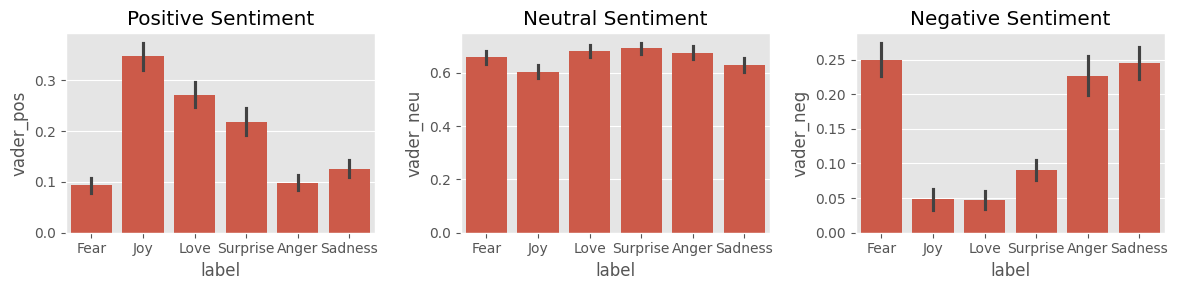

In [36]:
fig, axs = plt.subplots(1, 3, figsize = (12, 3)) 
sns.barplot(data = vaders, x = 'label', y = 'vader_pos', ax = axs[0]) 
sns.barplot(data = vaders, x = 'label', y = 'vader_neu', ax = axs[1]) 
sns.barplot(data = vaders, x = 'label', y = 'vader_neg', ax = axs[2]) 
axs[0].set_title('Positive Sentiment') 
axs[1].set_title('Neutral Sentiment') 
axs[2].set_title('Negative Sentiment') 
plt.tight_layout()
plt.show() 

# RoBERTa Model

In [37]:
from transformers import AutoTokenizer 
from transformers import AutoModelForSequenceClassification 
from scipy.special import softmax 

In [38]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment-latest"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

c:\Program Files\Python312\Lib\site-packages\transformers\tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exac

In [39]:
print(example) 
sia.polarity_scores(example)

feel like hope gained wisdom still choices struggle decisions afraid make fear long term ramifications still pieces feel like know better


{'neg': 0.156, 'neu': 0.368, 'pos': 0.476, 'compound': 0.8834}

In [40]:
encoded_text = tokenizer(example, return_tensors='pt')
output = model(**encoded_text) 
scores = output[0][0].detach().numpy() 
scores = softmax(scores) 
scores_dict = {
    'roberta_neg' : scores[0], 
    'roberta_neu' : scores[1], 
    'roberta_pos' : scores[2]
} 
print(scores_dict)

{'roberta_neg': np.float32(0.053623352), 'roberta_neu': np.float32(0.44727978), 'roberta_pos': np.float32(0.49909696)}


In [41]:
def polarity_scores_roberta(example): 
    encoded_text = tokenizer(example, return_tensors='pt')
    output = model(**encoded_text) 
    scores = output[0][0].detach().numpy() 
    scores = softmax(scores) 
    scores_dict = {
        'roberta_neg' : scores[0], 
        'roberta_neu' : scores[1], 
        'roberta_pos' : scores[2]
    } 
    return scores_dict


In [42]:
res = {}

for i, row in tqdm( df.iterrows(), total = len(df) ): 
    try: 
        text = row['text'] 
        id = row['Index']
        vader_result = sia.polarity_scores(text)
        vader_result_rename = {} 

        for key, value in vader_result.items(): 
            vader_result_rename[f"vader_{key}"] = value
        roberta_result = polarity_scores_roberta(text)
        both = {**vader_result, ** roberta_result}
        res[id] = both
    except RuntimeError: 
        print(f'Broke for id {id}') 

  0%|          | 0/1000 [00:00<?, ?it/s]

In [43]:
results_df = pd.DataFrame(res).T 
results_df = results_df.reset_index().rename(columns={
    'index': 'Id', 
    'neg': 'vader_neg', 
    'neu': 'vader_neu', 
    'pos': 'vader_pos'
}) 

if 'Index' in df.columns: 
    results_df = results_df.merge(df, how = 'left', left_on = 'Id', right_on = 'Index')
else: 
    results_df = results_df.merge(df, how = 'left', left_on = 'Id', right_index = True)

In [44]:
results_df.head()

,Id,vader_neg,vader_neu,vader_pos,compound,roberta_neg,roberta_neu,roberta_pos,Index,text,label,processed_text,char_count,word_count,message_length,tokens,pos_tags
0,90,0.185,0.648,0.167,-0.3400,0.892228,0.100251,0.007521,90,i don t want to sit inside and be alone i don ...,Fear,"[want, sit, inside, alone, want, nothing, also...",55,10,Short,"[want, sit, inside, alone, want, nothing, also...","[(want, JJ), (sit, NN), (inside, IN), (alone, ..."
1,90,0.185,0.648,0.167,-0.3400,0.892228,0.100251,0.007521,90,i don t want to sit inside and be alone i don ...,Fear,"[want, sit, inside, alone, want, nothing, also...",55,10,Short,"[want, sit, inside, alone, want, nothing, also...","[(want, JJ), (sit, NN), (inside, IN), (alone, ..."
2,161,0.000,0.778,0.222,0.6757,0.021078,0.231373,0.747549,161,i feel generous and i follow but mostly i endu...,Joy,"[feel, generous, follow, mostly, endure, like,...",78,13,Long,"[feel, generous, follow, mostly, endure, like,...","[(feel, NN), (generous, JJ), (follow, VBP), (m..."
3,161,0.000,0.778,0.222,0.6757,0.021078,0.231373,0.747549,161,i feel generous and i follow but mostly i endu...,Joy,"[feel, generous, follow, mostly, endure, like,...",78,13,Long,"[feel, generous, follow, mostly, endure, like,...","[(feel, NN), (generous, JJ), (follow, VBP), (m..."
4,568,0.074,0.617,0.309,0.8449,0.031346,0.073847,0.894806,568,i am hopeful that normalcy is just around the ...,Love,"[hopeful, normalcy, around, corner, grateful, ...",74,12,Long,"[hopeful, normalcy, around, corner, grateful, ...","[(hopeful, JJ), (normalcy, NN), (around, IN), ..."


# Comparative Analysis

In [45]:
results_df.columns

Index(['Id', 'vader_neg', 'vader_neu', 'vader_pos', 'compound', 'roberta_neg',
       'roberta_neu', 'roberta_pos', 'Index', 'text', 'label',
       'processed_text', 'char_count', 'word_count', 'message_length',
       'tokens', 'pos_tags'],
      dtype='object')

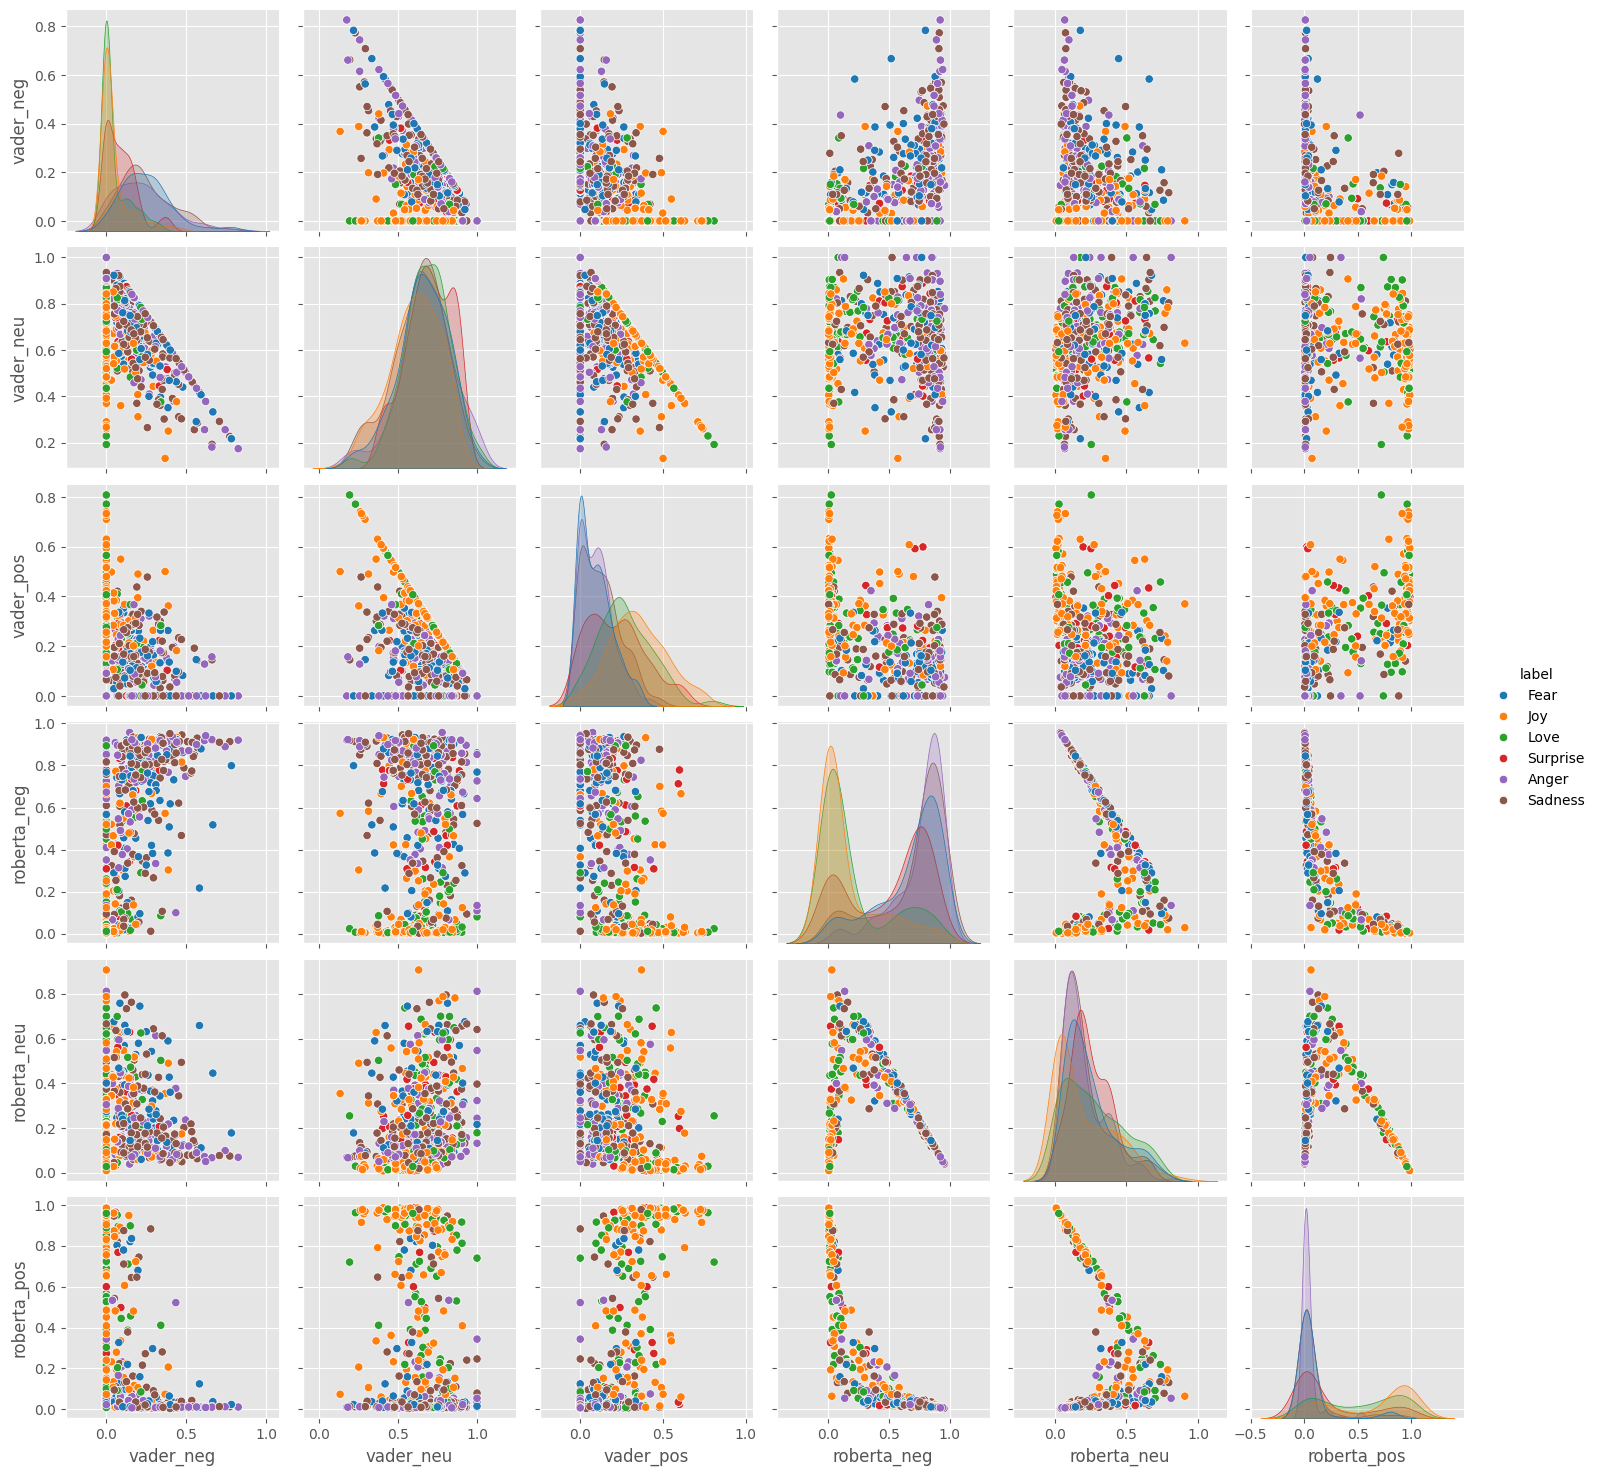

In [46]:
sns.pairplot(
    data = results_df, 
    vars = [
        'vader_neg', 'vader_neu', 'vader_pos', 
        'roberta_neg', 'roberta_neu', 'roberta_pos'
    ], 
    hue = 'label', 
    palette = 'tab10'
) 
plt.show()

# Examples

In [47]:
results_df.query('label == "Joy"').sort_values('roberta_pos', ascending=False)['text'].values[0]

'i feel thrilled to be part of such a great team and a fabulous challenge'

In [48]:
results_df.query('label == "Joy"').sort_values('vader_pos', ascending=False)['text'].values[0]

'im feeling very joyful'

In [49]:
results_df.query('label == "Joy"').sort_values('roberta_neg', ascending=False)['text'].values[0]

'i feel shame for supporting iraq war why can t blair'

In [50]:
results_df.query('label == "Joy"').sort_values('vader_neg', ascending=False)['text'].values[0]

'im the customer i wont feel welcomed but intimidated'

# Transformers Pipeline

In [51]:
from transformers import pipeline 

sent_pipeline = pipeline("sentiment-analysis")

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


In [52]:
sent_pipeline('I love you')

[{'label': 'POSITIVE', 'score': 0.9998656511306763}]

In [53]:
sent_pipeline('Fire')

[{'label': 'NEGATIVE', 'score': 0.9753842353820801}]

In [54]:
sent_pipeline(example)

[{'label': 'NEGATIVE', 'score': 0.9744141697883606}]